In [1]:
import train as train
import generate
import eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
BASE_DIR = "./experiments/sanity_check"
PROFILE = "sin-1x"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-1x-10k ======


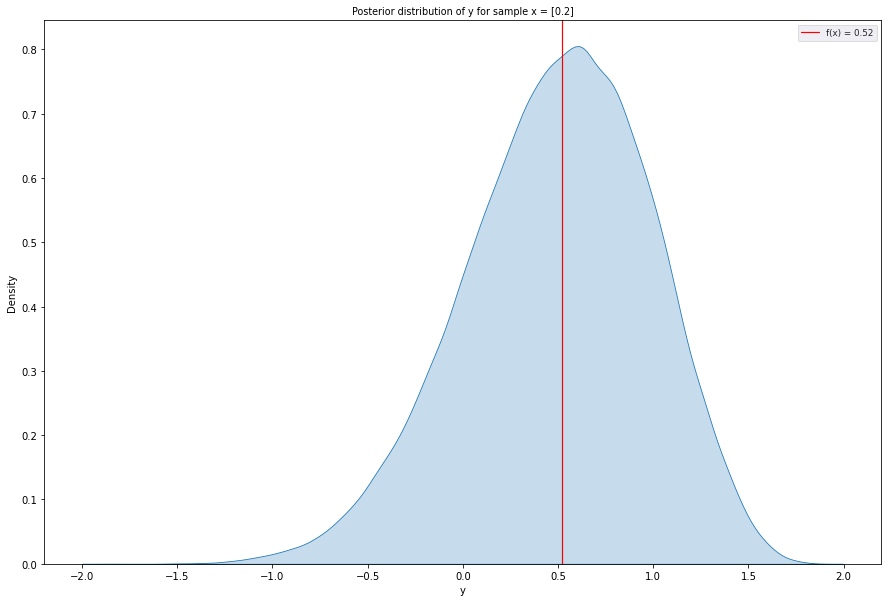

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
_, _, (x_test, y_test), (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_train=False, load_val=False)

In [6]:
x_test[0], y_test[0]

(tensor([-1.3894]), tensor(-1.2562))

<AxesSubplot:>

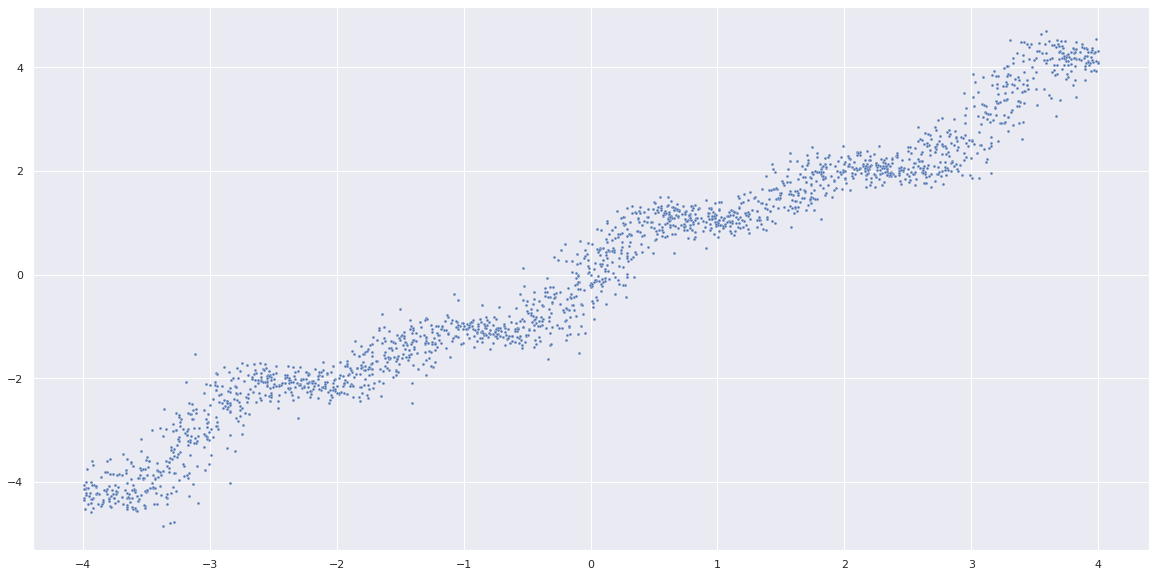

In [7]:
sns.set(rc = {'figure.figsize':(20,10)})
sns.scatterplot(x=x_test.flatten(), y=y_test, s=8)

In [8]:
if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    infer_model = train.train(config, f"{BASE_DIR}")

Using device: cpu
===== Training profile sin-1x =====


Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Training finished in 0:02:08.730352 seconds
Saved model and parameters to ./experiments/sanity_check/models/sin-1x


In [9]:
inference_model = eval.load_model(BASE_DIR, config)

Loaded model and parameters from ./experiments/sanity_check/models/sin-1x


In [10]:
predictive = inference_model.get_predictive(num_predictions=500)
samples = predictive(x_test)
samples.keys()

dict_keys(['sigma', 'obs', '_RETURN'])

In [11]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

pred_summary = summary(samples)

In [12]:
y = pred_summary["obs"]
mu = pred_summary["_RETURN"]
predictions = pd.DataFrame({
    "x": x_test.flatten(),
    "mu": mu["mean"].flatten(),
    "mu_5": mu["5%"].flatten(),
    "mu_95": mu["95%"].flatten(),
    "y_mean": y["mean"].flatten(),
    "y_5": y["5%"].flatten(),
    "y_95": y["95%"].flatten(),
    "true_y": y_test.flatten()
})

In [13]:
predictions.head()

,x,mu,mu_5,mu_95,y_mean,y_5,y_95,true_y
0,-1.389394,-1.302049,-2.262722,-0.386243,-1.373591,-3.067893,0.331923,-1.256200
1,-2.453752,-1.832625,-3.038707,-0.643250,-1.832895,-3.819079,-0.097330,-2.327538
2,1.408900,1.493577,0.875437,2.148544,1.437632,-0.119964,2.954203,1.626828
3,1.313301,1.447858,0.841646,2.096364,1.481629,-0.072427,3.044449,1.236008
4,0.570066,0.877191,0.215438,1.545027,0.909033,-0.775383,2.583126,1.121639


In [14]:
sorted_pred = predictions.sort_values(by='x')

def plot_predictions(summary):
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['mu'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['mu_5'], y2=summary['mu_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)
    
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['y_mean'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['y_5'], y2=summary['y_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)

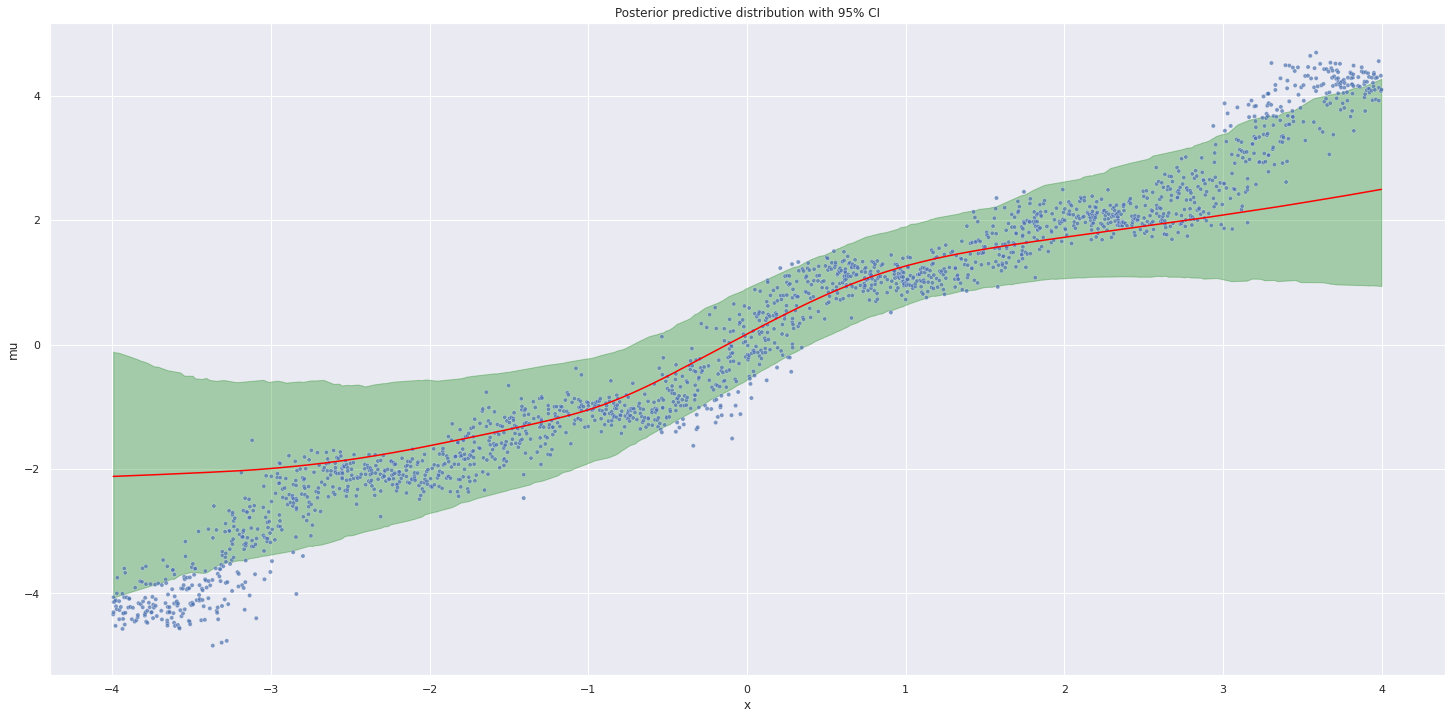

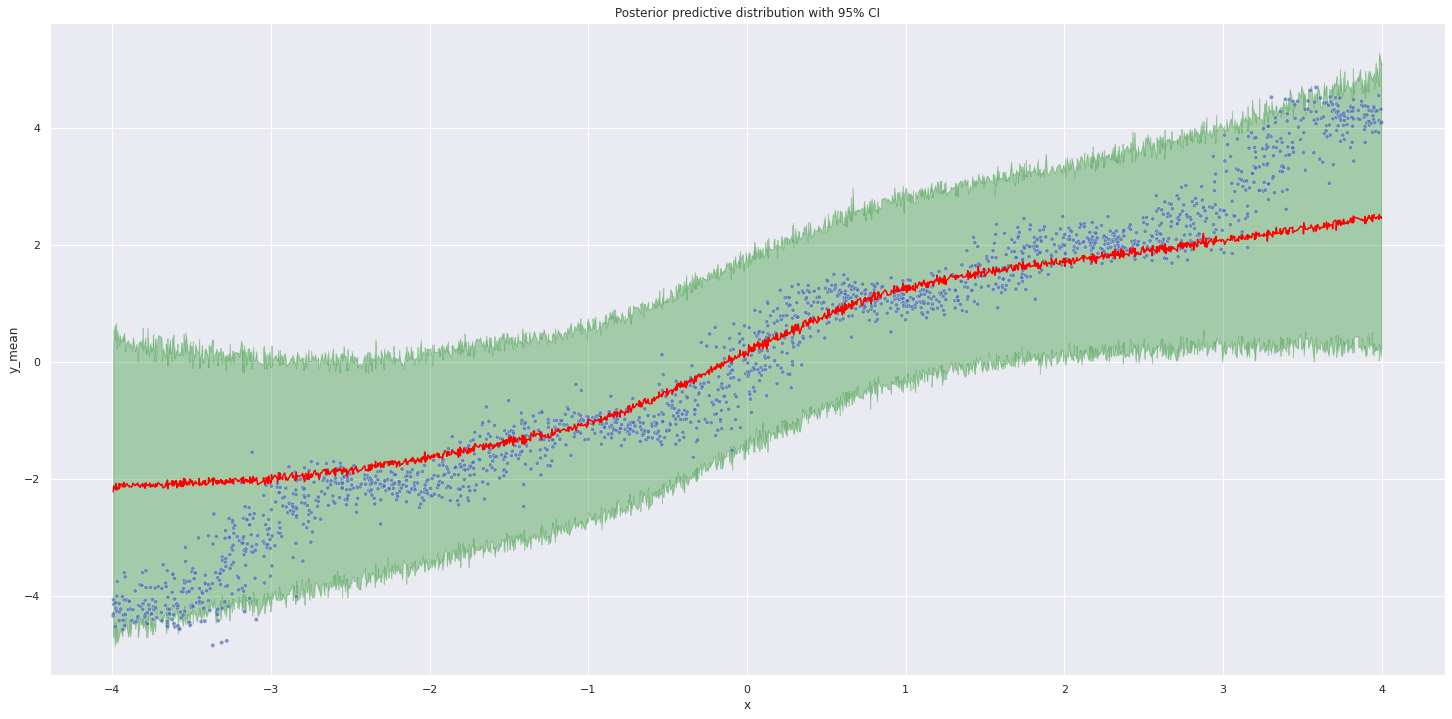

In [15]:
plot_predictions(sorted_pred)

Loaded model and parameters from ./experiments/sanity_check/models/sin-1x
using device: cpu
====== evaluating profile sin-1x ======
Eval done in 0:01:34.398125


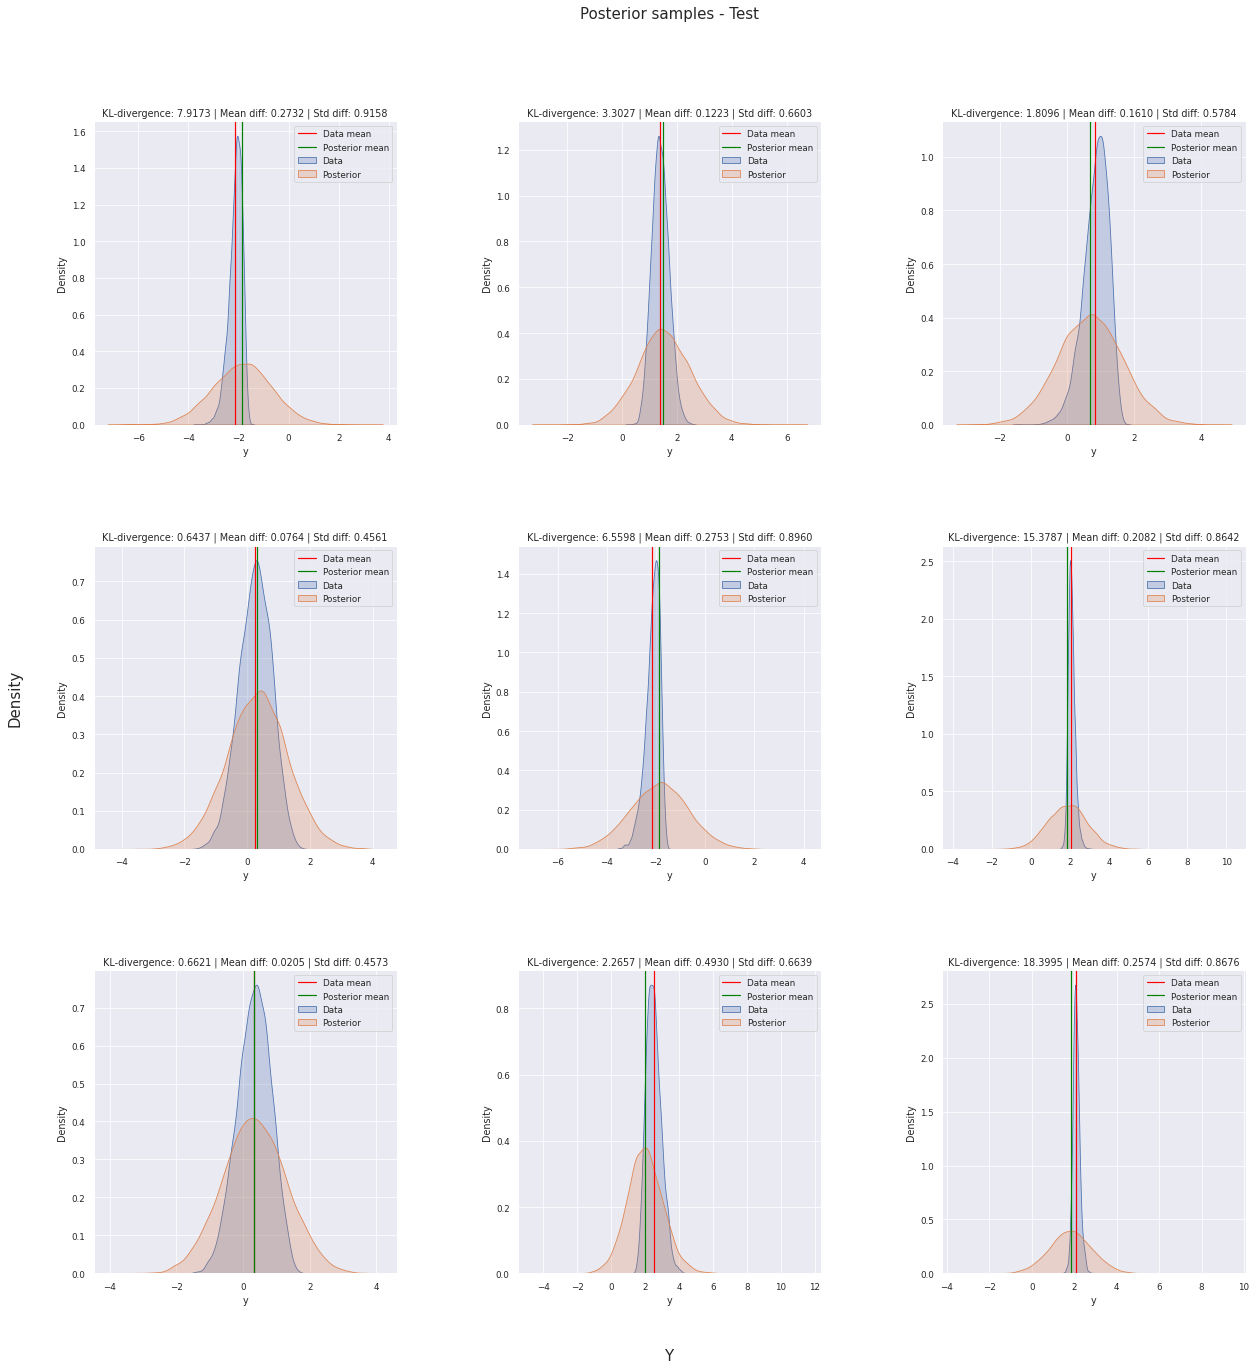

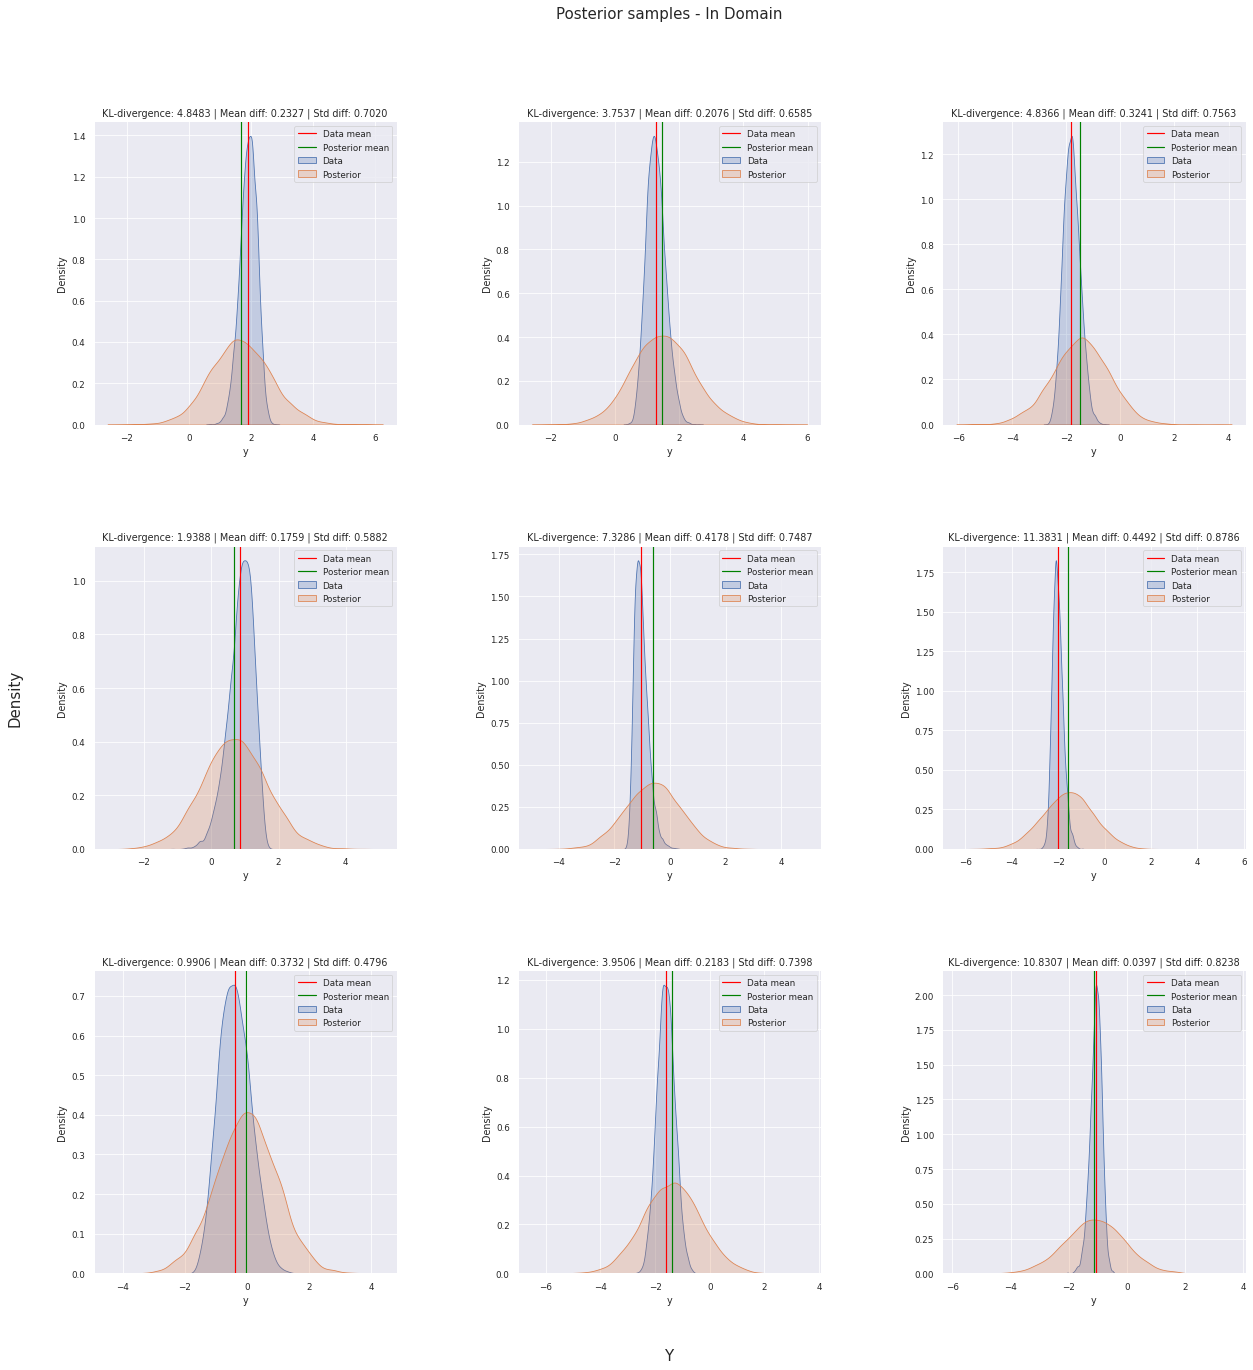

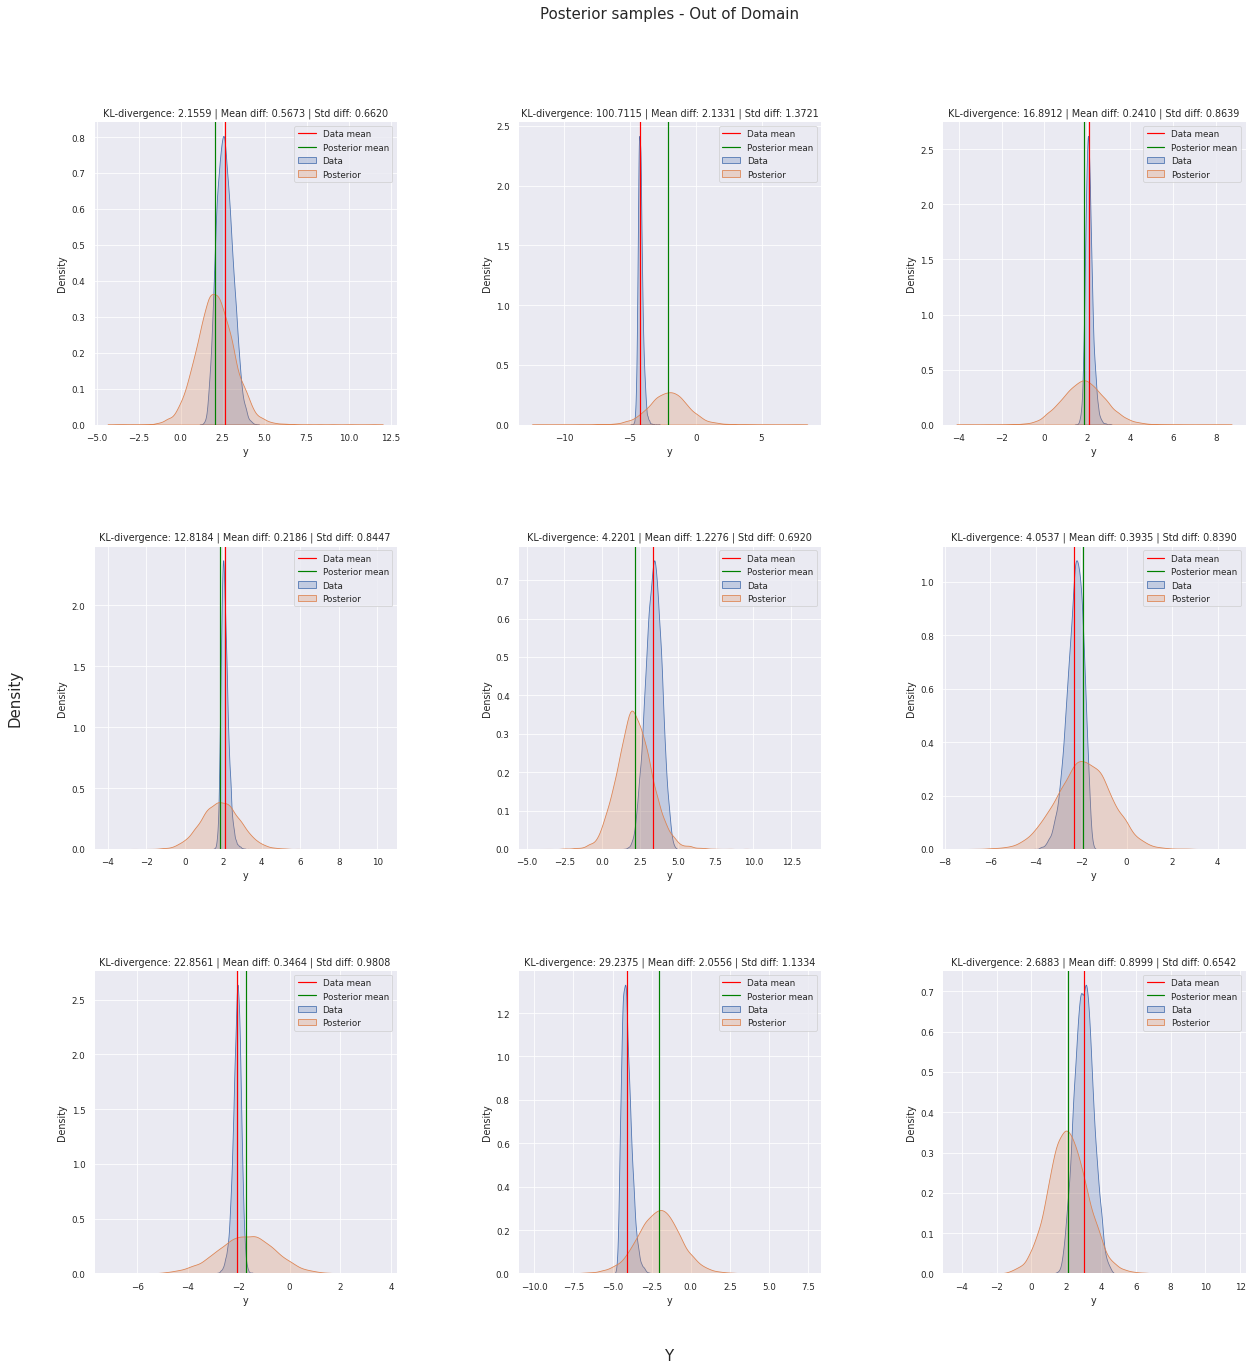

In [16]:
if True:
            if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")

            eval.eval(config, dataset_config, f"{BASE_DIR}")